In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas
from patsy import dmatrices
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
from  sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
import sys 
#sys.path.append("/mnt/d/PHD/ISPRA_20152017_Analysis/modules/")
from plotting import * 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
from scipy import stats 
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import sys 
_HOME_ = "/mnt/d"
import plotting 
import modify_dataset
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
import json
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import HDBSCAN

/home/alberto/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Basics variables and parameters

In [2]:
phyto_abundances = pd.read_csv(_HOME_ + "/PHD/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [3]:
with open(_HOME_ + "/PHD/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [4]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [5]:
taxonomic_tree = pd.read_excel(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [6]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [7]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [8]:
transects_info = pd.read_csv("/mnt/d/PHD/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

## Clustering

In [9]:
def build_linkage_matrix(model) -> np.ndarray : 
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

remove irrelevant samples

In [10]:
min_taxa = 5
min_abund = 1000
relevant_samples = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["id", "Date"], observed=True).agg({"Taxon" : "count", "Num_cell_l" : "sum"}).query("Taxon > @min_taxa or Num_cell_l > @min_abund").index

In [11]:
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]

In [12]:
count_thesh = 0
abund_thresh = 0
relevant_taxa = phyto_abund_simplified.query("Taxon not in @higher_than_class").groupby("Taxon").agg(
    count = ("id", "count"),
    abund = ("Num_cell_l", "sum")
).query("count >= @count_thesh or abund >= @abund_thresh").index

In [13]:
sites_species = phyto_abund_simplified.set_index(["id", "Date"]).loc[relevant_samples, ["Taxon", "Num_cell_l"]].query("Taxon in @relevant_taxa").pivot_table(index = ["id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0)

hellinger transformation and PCA reduction

In [14]:
abund_hellinger = sites_species.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.to_numpy()

In [15]:
pca = decomposition.PCA()

In [16]:
pca.fit(X)

PCA()

In [17]:
cum_variance = np.cumsum(pca.explained_variance_ratio_) / np.sum(pca.explained_variance_ratio_)

In [18]:
cum_variance[150]

0.9598365732134098

In [19]:
X_transformed = pca.transform(X)[:, :150]

testing various methods

In [70]:
silhouette_scores = {}
calisnki_scores = {}
davies_scores = {}

single linkage

In [117]:
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "single", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(linkage_clusters)

In [118]:
method = "single"
n_clusters = np.arange(3,200,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
for i, n in enumerate(n_clusters):
    labels = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, labels)
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, labels)
    davies[i] = metrics.davies_bouldin_score(X_transformed, labels)
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies

ward

In [119]:
ward_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
ward_clusters = ward_clustering.fit(X_transformed)
linkage_matrix = build_linkage_matrix(ward_clusters)

In [120]:
method = "ward"
n_clusters = np.arange(3,200,1)
silhouette = np.empty(n_clusters.size)
calisnki = np.empty(n_clusters.size)
davies = np.empty(n_clusters.size)
for i, n in enumerate(n_clusters):
    labels = fcluster(linkage_matrix, t = n, criterion = "maxclust")
    silhouette[i] = metrics.silhouette_score(X_transformed, labels)
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed, labels)
    davies[i] = metrics.davies_bouldin_score(X_transformed, labels)
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies

In [110]:
method = "HDBSCAN"
min_cluster_sizes = np.arange(3, 100, 1)
n_clusters_hdb = np.empty(min_cluster_sizes.size)
silhouette = np.empty(min_cluster_sizes.size)
calisnki = np.empty(min_cluster_sizes.size)
davies = np.empty(min_cluster_sizes.size)
non_noisy_samples = np.empty(min_cluster_sizes.size)
for i, min_cluster_size in tqdm(enumerate(min_cluster_sizes)): 
    hdb = HDBSCAN(min_cluster_size=min_cluster_size, metric="euclidean")
    hdb_clusters = hdb.fit_predict(X_transformed)
    if np.all(np.unique(hdb_clusters) == -1): 
        break
    silhouette[i] = metrics.silhouette_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1])
    calisnki[i] = metrics.calinski_harabasz_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1])
    davies[i] = metrics.davies_bouldin_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1])
    non_noisy_samples[i] = np.sum(hdb_clusters != -1)
    n_clusters_hdb[i] = np.sum(np.unique(hdb_clusters) != -1)
silhouette_scores[method] = silhouette
calisnki_scores[method] = calisnki
davies_scores[method] = davies

37it [00:54,  1.47s/it]


Text(0.5, 1.0, 'Davies Bouldin score')

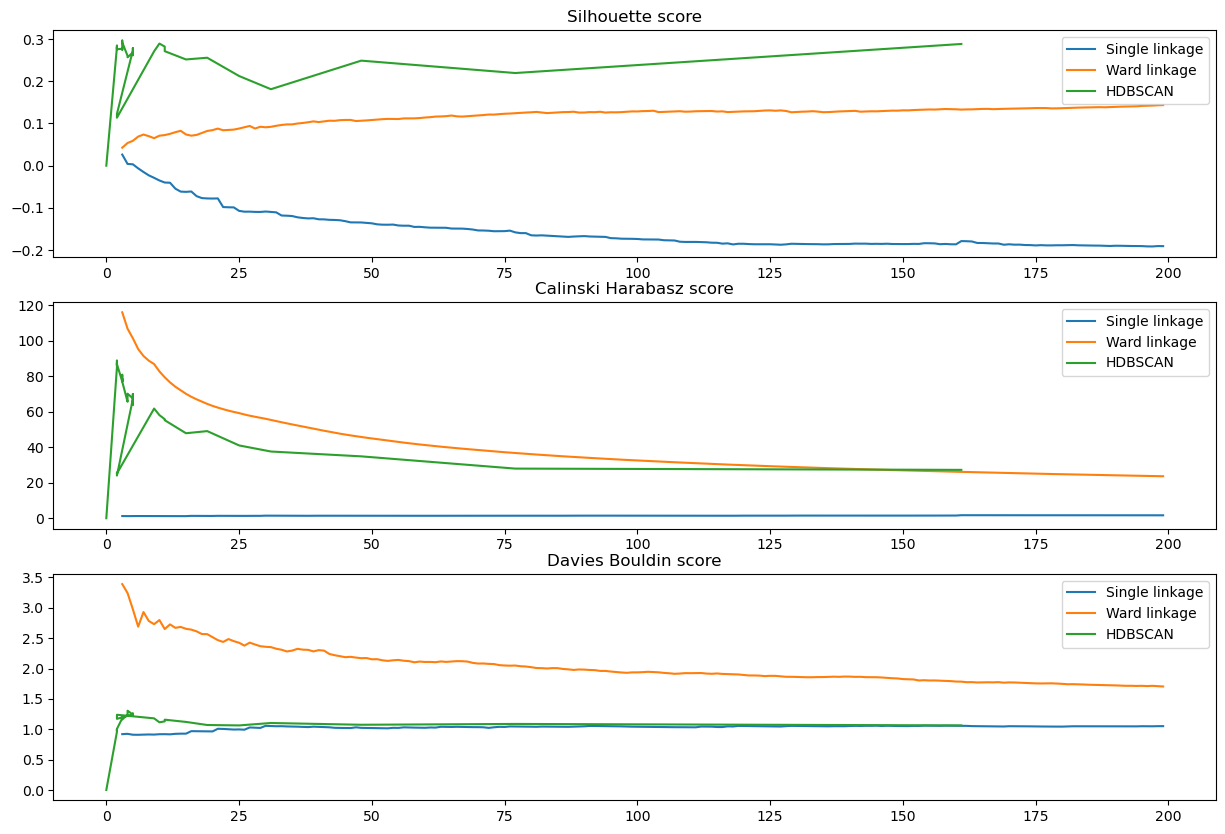

In [121]:
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs[0].plot(n_clusters, silhouette_scores["single"], label = "Single linkage")
axs[0].plot(n_clusters, silhouette_scores["ward"], label = "Ward linkage")
axs[0].plot(n_clusters_hdb, silhouette_scores["HDBSCAN"], label = "HDBSCAN")
axs[0].legend()
axs[0].set_title("Silhouette score")
axs[1].plot(n_clusters, calisnki_scores["single"], label = "Single linkage")
axs[1].plot(n_clusters, calisnki_scores["ward"], label = "Ward linkage")
axs[1].plot(n_clusters_hdb, calisnki_scores["HDBSCAN"], label = "HDBSCAN")
axs[1].legend()
axs[1].set_title("Calinski Harabasz score")
axs[2].plot(n_clusters, davies_scores["single"], label = "Single linkage")
axs[2].plot(n_clusters, davies_scores["ward"], label = "Ward linkage")
axs[2].plot(n_clusters_hdb[:-1], davies_scores["HDBSCAN"][:-1], label = "HDBSCAN")
axs[2].legend()
axs[2].set_title("Davies Bouldin score")

In [25]:
min_cluster_sizes = np.arange(3, 100, 1)

hdb = HDBSCAN(min_cluster_size=3, metric="euclidean", gen_min_span_tree=True)
hdb_clusters = hdb.fit_predict(X_transformed)
print(metrics.silhouette_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1]),
        metrics.calinski_harabasz_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1]),
        metrics.davies_bouldin_score(X_transformed[hdb_clusters != -1], hdb_clusters[hdb_clusters != -1]))

-0.08288945269256244 7.9101514389430925 1.5038676213758437


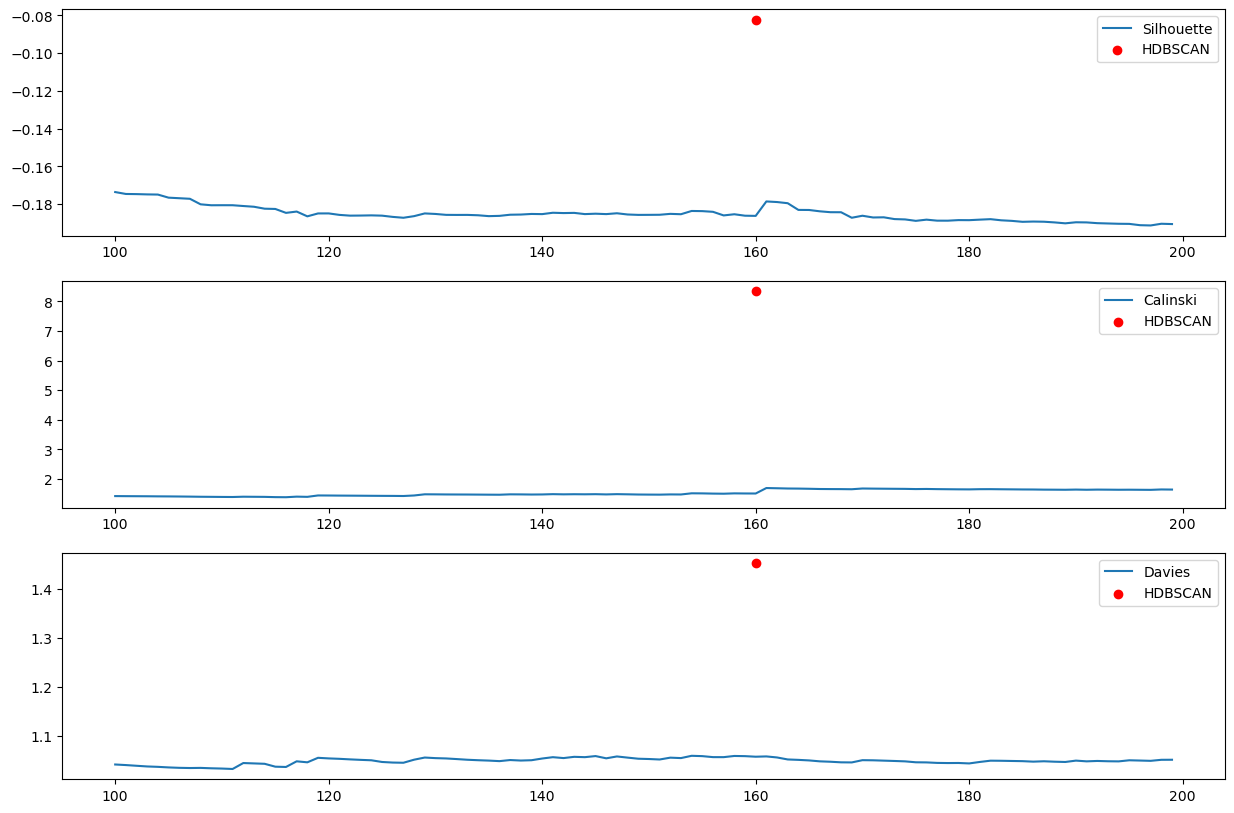

In [26]:
points = X_transformed
fig, axs = plt.subplots(3,1, figsize = (15,10))
axs[0].plot(n_clusters, silhouette, label = "Silhouette")
axs[0].scatter(np.max(hdb_clusters), metrics.silhouette_score(points, hdb_clusters), color = "red", label = "HDBSCAN")
axs[0].legend()
axs[1].plot(n_clusters, calisnki, label = "Calinski")
axs[1].scatter(np.max(hdb_clusters), metrics.calinski_harabasz_score(points, hdb_clusters), color = "red", label = "HDBSCAN")
axs[1].legend()
axs[2].plot(n_clusters, davies, label = "Davies")
axs[2].scatter(np.max(hdb_clusters), metrics.davies_bouldin_score(points, hdb_clusters), color = "red", label = "HDBSCAN")
axs[2].legend()

In [66]:
clustered_sites = pd.DataFrame(
    {
        "id" : sites_species.index.get_level_values("id"),
        "Date" : sites_species.index.get_level_values("Date"),
        "HDBSCAN" : hdb_clusters, 
        "prob_clus" : hdb.probabilities_
    }
).merge(phyto_abund_simplified[["id", "Region", "Season", "Date"]].drop_duplicates(), how = "left", on = ["id", "Date"])

In [35]:
clustered_sites.groupby("HDBSCAN").agg({"id" : "count"}).sort_values("id", ascending = False)

,id
HDBSCAN,
-1,1172
159,45
41,31
156,23
119,22
...,...
118,3
25,3
24,3


In [55]:
clustered_sites.query("HDBSCAN == 159").sort_values(["Region", "id", "Date"])

,id,Date,HDBSCAN,Region,Season
963,6CB04,2016-03-31,159,Puglia,Winter
1062,9PN03,2016-03-31,159,Puglia,Winter
1975,SMR_CCE_WA3,2017-05-31,159,Toscana,Spring
1987,SMR_CCE_WA5,2017-05-31,159,Toscana,Spring
2059,SMR_COM_WA5,2017-06-30,159,Toscana,Spring
2086,SMR_CPI_WA3,2017-11-30,159,Toscana,Autumn
104,0129-MS00730_TR03,2015-08-31,159,Sardegna,Summer
106,0129-MS00730_TR03,2015-11-30,159,Sardegna,Autumn
113,0129-MS00730_TR03,2017-01-31,159,Sardegna,Winter
114,0129-MS00730_TR03,2017-03-31,159,Sardegna,Winter


In [67]:
hdb_cluster_statistic = clustered_sites.query("HDBSCAN != -1").groupby("HDBSCAN").agg(
    samples = ("id", "count"),
    region = ("Region", "nunique"),
    season = ("Season", "nunique"),
    sites = ("id", "nunique"), 
    mean_prob = ("prob_clus", "mean")
)

In [68]:
pd.set_option('display.max_rows', None)
hdb_cluster_statistic.sort_values("samples", ascending = False)

,samples,region,season,sites,mean_prob
HDBSCAN,,,,,
159,45,3,4,15,0.959383
41,31,2,3,26,0.907731
156,23,6,4,19,0.997039
119,22,1,4,9,0.994564
16,21,6,4,16,0.377238
82,18,1,3,12,0.874057
120,15,2,3,10,0.948061
62,15,1,3,8,0.962551
68,15,1,2,8,0.934438


In [61]:
pd.reset_option('display.max_rows')
hdb_cluster_statistic

,samples,region,season,sites
HDBSCAN,,,,
0,3,2,2,3
1,3,1,2,2
2,6,1,1,6
3,3,1,1,3
4,5,1,1,4
...,...,...,...,...
156,23,6,4,19
157,6,1,2,4
158,8,1,1,8


In [44]:
good_samples = clustered_sites.query("HDBSCAN != -1")[["id", "Date"]].set_index(["id", "Date"]).index

In [47]:
pca_good_samples = decomposition.PCA().fit(abund_hellinger.loc[good_samples].to_numpy())

In [ ]:
for n in n_clusters:
    H_clusters = AgglomerativeClustering(n_clusters = 15, metric = "euclidean", linkage = "ward", compute_distances = True)
    hellinger_clusers = H_clusters.fit(X)
    metrics.silhouette_score(X, hellinger_clusers.labels_, metric = "euclidean")
    metrics.calinski_harabasz_score(X, hellinger_clusers.labels_)
    metrics.davies_bouldin_score(X, hellinger_clusers.labels_)

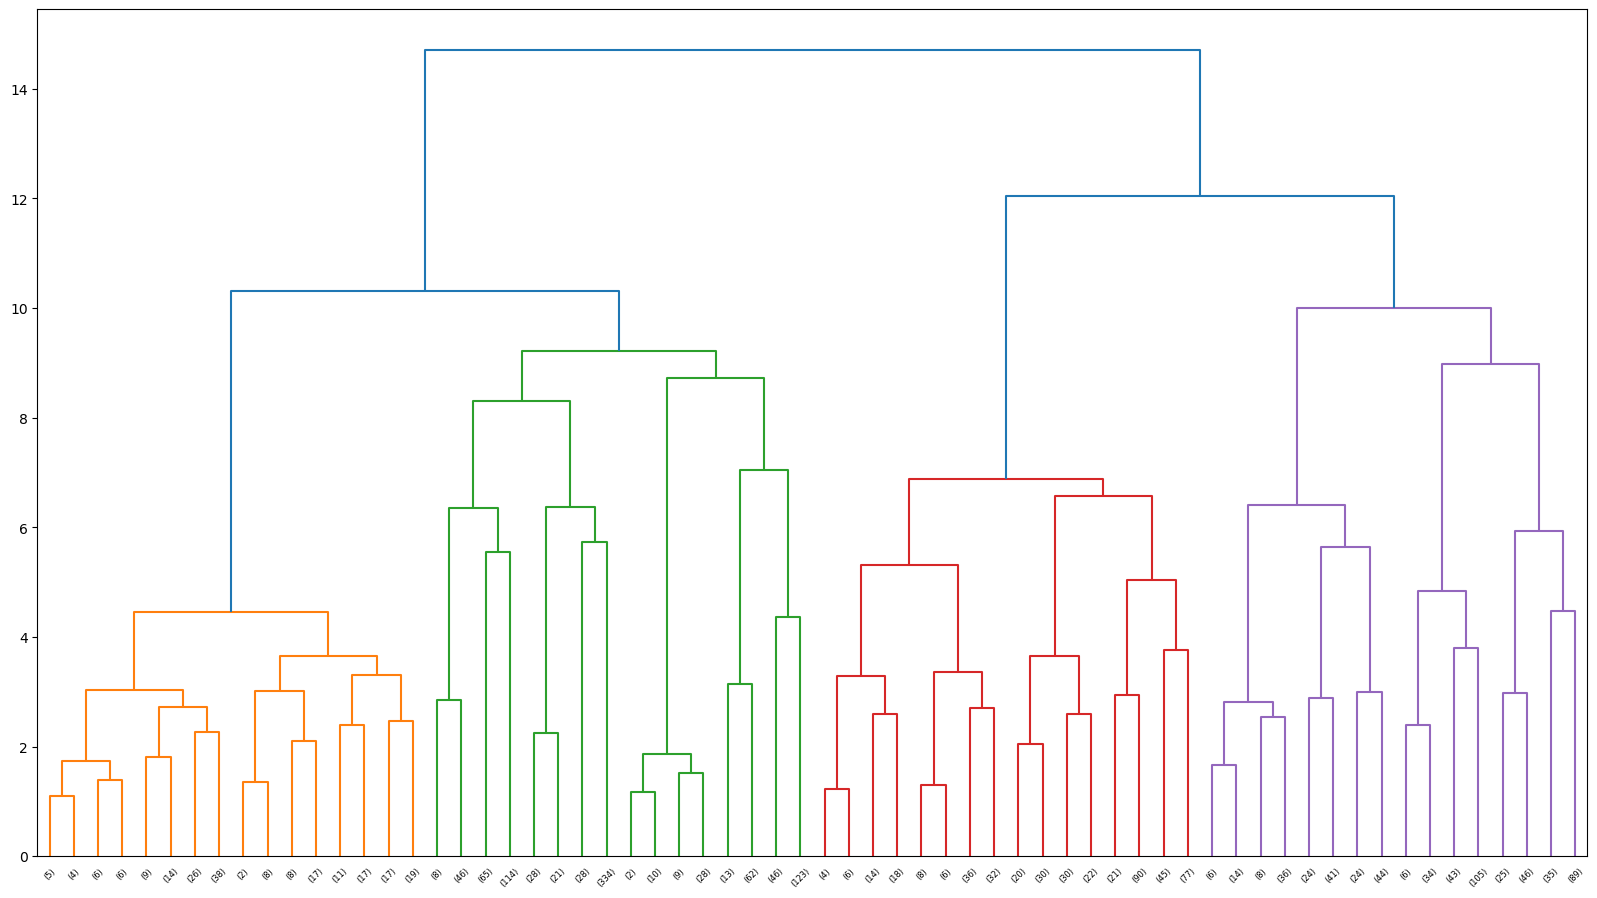

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20, 11))
R = plot_dendrogram(H_clusters, ax = ax, truncate_mode = "level", p = 5, leaf_rotation = 45)
#xlabels = ax.get_xticklabels()
#ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");

# other stuff

In [24]:
Z = create_linkage_matrix(hellinger_clusers)s

In [26]:
dist = pdist(abund_hellinger.T, metric="euclidean")

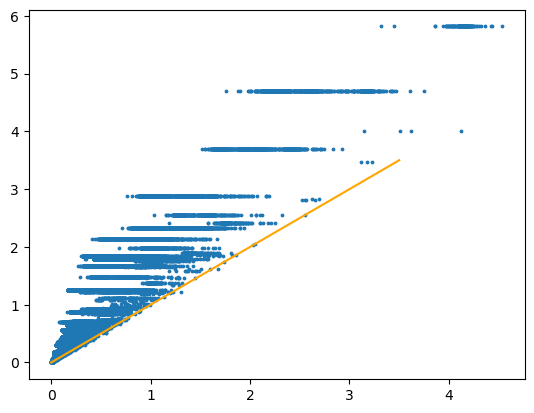

In [27]:
plt.scatter(dist, cophenet(Z), s = 3)
plt.plot(np.linspace(0,3.5, 3), np.linspace(0,3.5, 3), "orange")

In [28]:
stats.spearmanr(dist, cophenet(Z))

SignificanceResult(statistic=0.9340608582709521, pvalue=0.0)

In [7]:
scaler = StandardScaler()

In [8]:
data_scaled = scaler.fit_transform(abund_hellinger.T)

In [9]:
pca = decomposition.PCA()
pca.fit(data_scaled)

PCA()

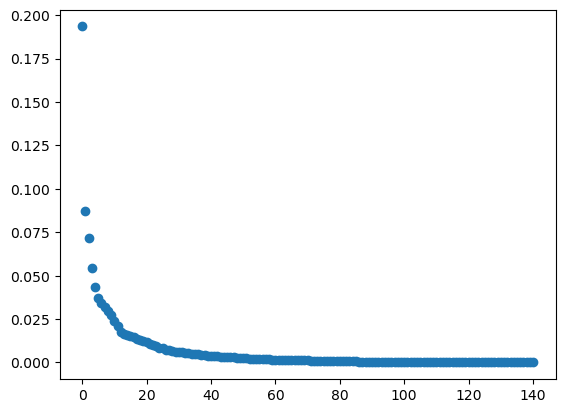

In [10]:
plt.scatter(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [11]:
np.sum(pca.explained_variance_ratio_[:5])

0.45039337428847803

In [59]:
ldngs = pca.components_.shape

(141, 141)

In [80]:
pca.components_.shape

(141, 141)

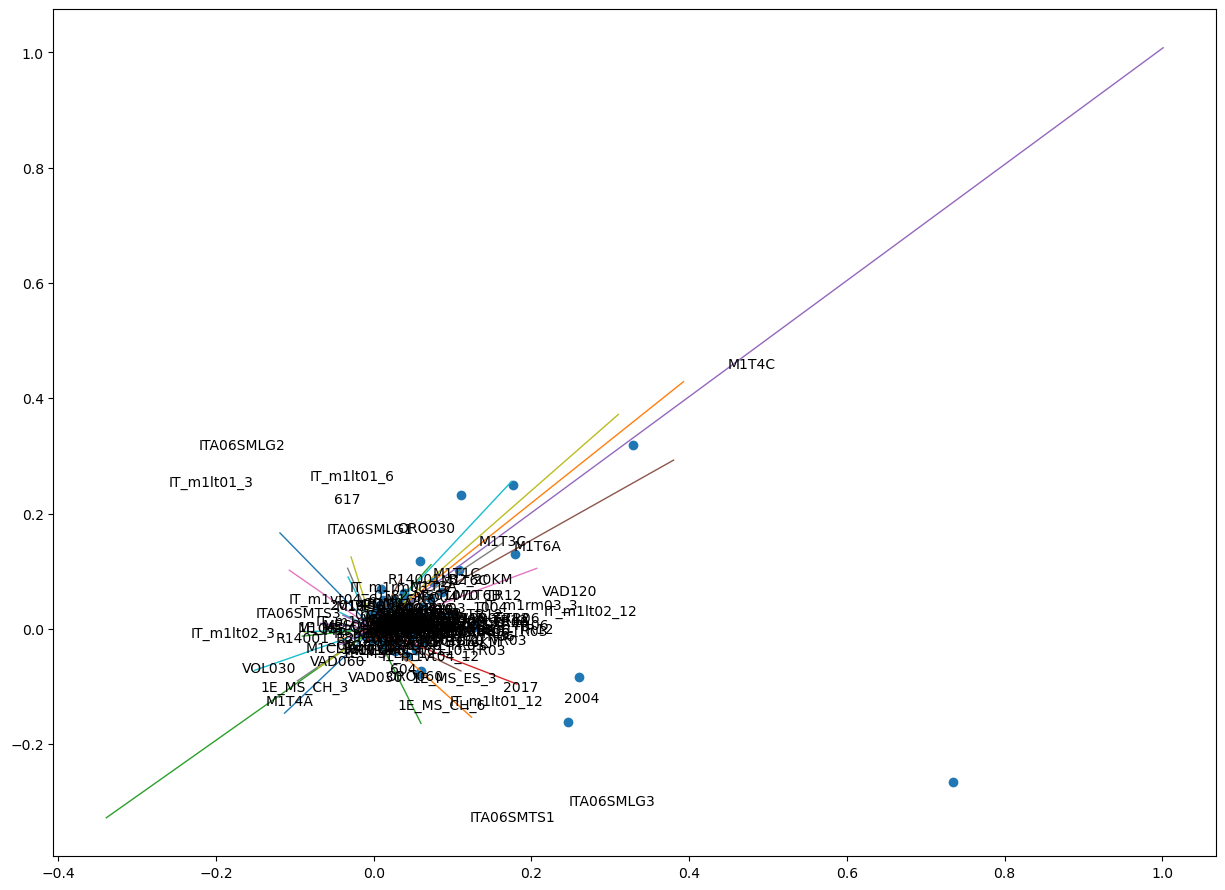

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
transformed = pca.transform(data_scaled)
X = transformed[:, 0] / (max(transformed[:, 0]) - min(transformed[:, 1]))
Y = transformed[:, 1]  / (max(transformed[:, 0]) - min(transformed[:, 1]))
plt.scatter(X,Y)
for  station, pos in zip(abund_hellinger.index.get_level_values(1).to_list(), pca.components_):
    ax.annotate(station, (pos[0], pos[1]))
    
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp *var # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=1,
    )

Cluster with spearman

In [23]:
spear = abund.corr("spearman")

In [24]:
S_clusters = AgglomerativeClustering(n_clusters = 10, metric = "precomputed", linkage = "average", compute_distances = True)

In [25]:
spear_clusters = S_clusters.fit(spear.apply(lambda x: np.sqrt(1 - x)).to_numpy())

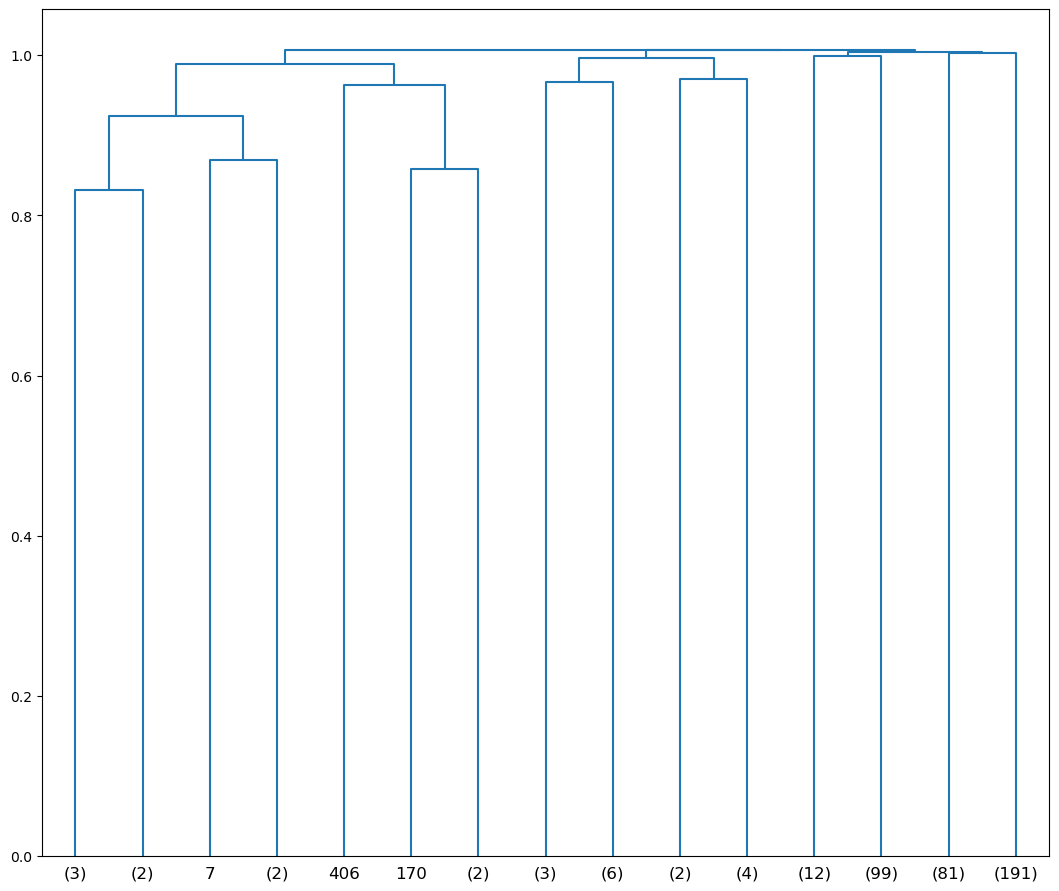

In [28]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
plot_dendrogram(spear_clusters, ax = ax, truncate_mode = "level", p = 3)

In [31]:
Z = create_linkage_matrix(spear_clusters)
dist = pdist(np.sqrt(1 - spear))

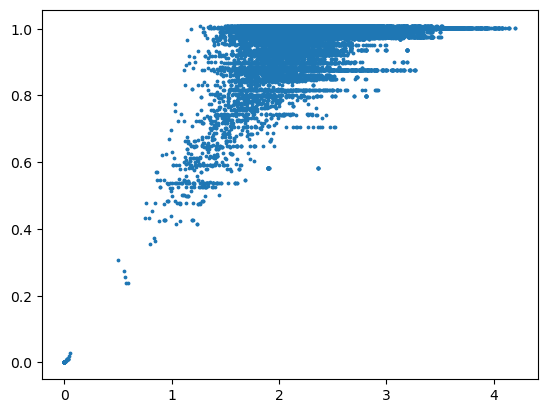

In [32]:
plt.scatter(dist, cophenet(Z), s = 3)
#plt.plot(np.linspace(0,3.5, 3), np.linspace(0,3.5, 3), "orange")

check species have been observed only once 

In [13]:
col_1_obs = np.where(abund.apply(lambda x: sum(x.astype(bool))) == 1)[0]
rows_with_obs = np.where(
    ~(abund.iloc[:, col_1_obs]==0).all(axis = 1)
)[0]

In [17]:
abund.iloc[rows_with_obs, col_1_obs].apply(lambda x: sum(x.astype(bool)), axis = 1).sort_values()

Calabria               M1T1A          1
Lazio                  IT_m1vt04_3    1
Liguria                MES120         1
                       VAD060         1
                       VOL030         1
                                     ..
Calabria               M1T3A          3
Puglia                 6CB02bis       3
Friuli-Venezia-Giulia  ITA06SMTS2     3
Emilia-Romagna         604            3
Puglia                 1CA03          4
Length: 68, dtype: int64

apply cluster to standardized values

In [14]:
log_trans = abund_hellinger.apply(lambda x: np.log(x + 1))

In [15]:
log_trans = log_trans.apply(lambda x: x / np.max(x), axis = 1)

In [11]:
H_clusters = AgglomerativeClustering(n_clusters = 10, metric = "euclidean", linkage = "ward", compute_distances = True)

In [12]:
clusters = H_clusters.fit(log_trans.to_numpy().T) 

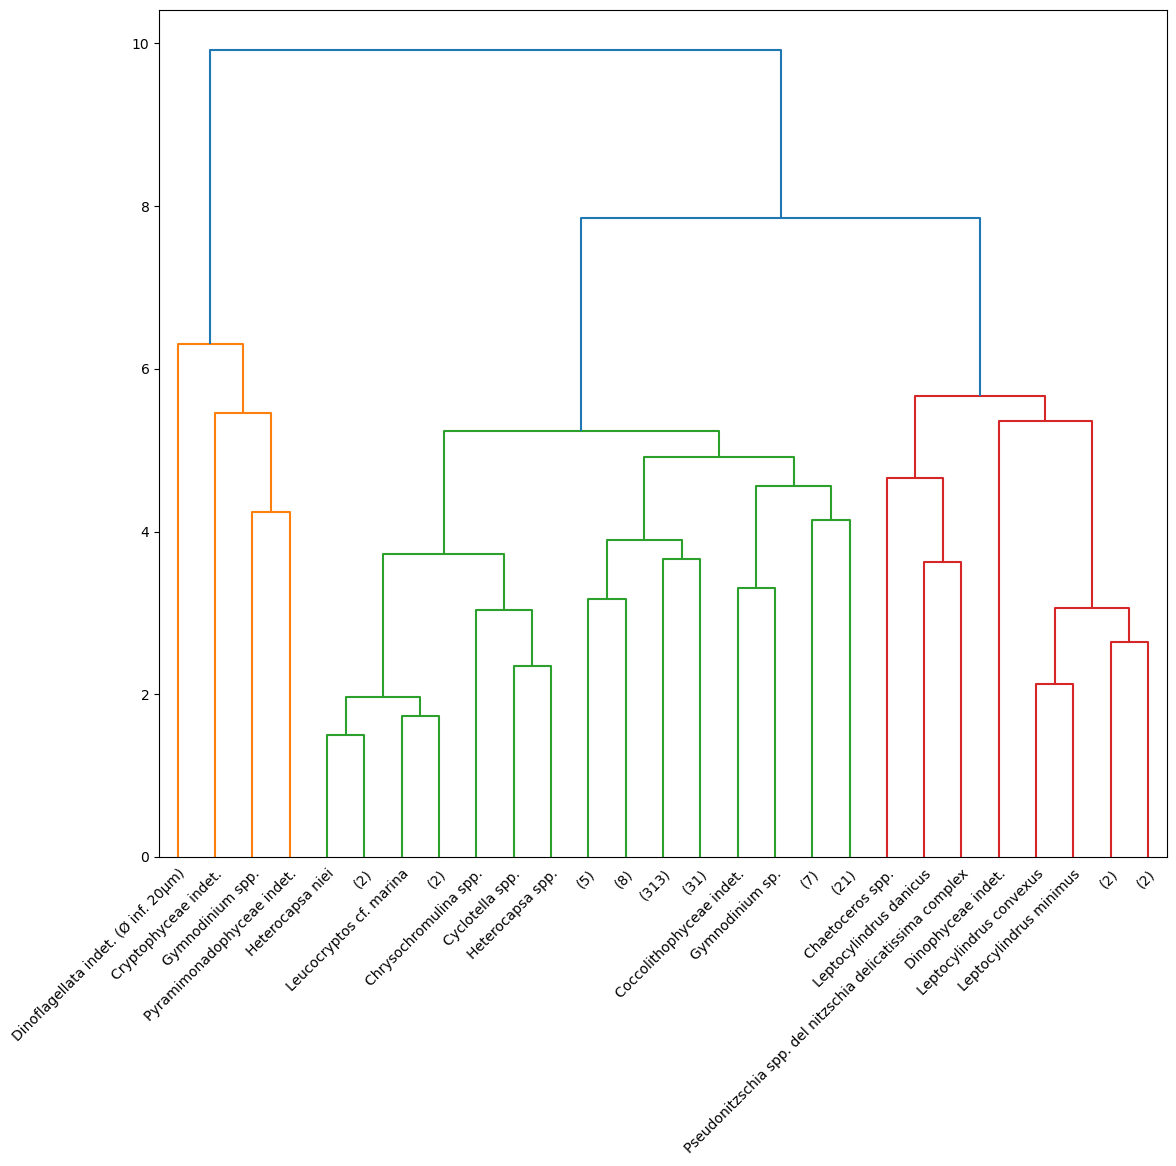

In [19]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
R = plot_dendrogram(clusters, ax = ax, truncate_mode = "level", p = 5, labels = species_list, leaf_rotation = 45)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, ha = "right", rotation_mode = "anchor");

In [38]:
abund.loc[:, ['Leptocylindrus convexus', 'Leptocylindrus minimus']].corr("spearman")

,Leptocylindrus convexus,Leptocylindrus minimus
Leptocylindrus convexus,1.000000,0.326337
Leptocylindrus minimus,0.326337,1.000000


In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(log_trans.T)

In [17]:
pca = decomposition.PCA()
pca.fit(log_trans.T)

PCA()

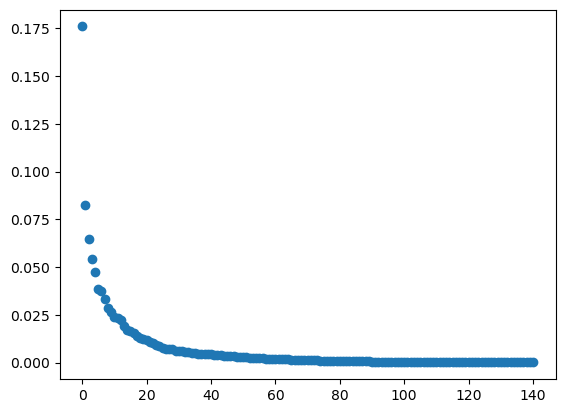

In [18]:
plt.scatter(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [19]:
pca.explained_variance_ratio_[:5]

array([0.17597175, 0.08255698, 0.0649109 , 0.05404601, 0.04760553])

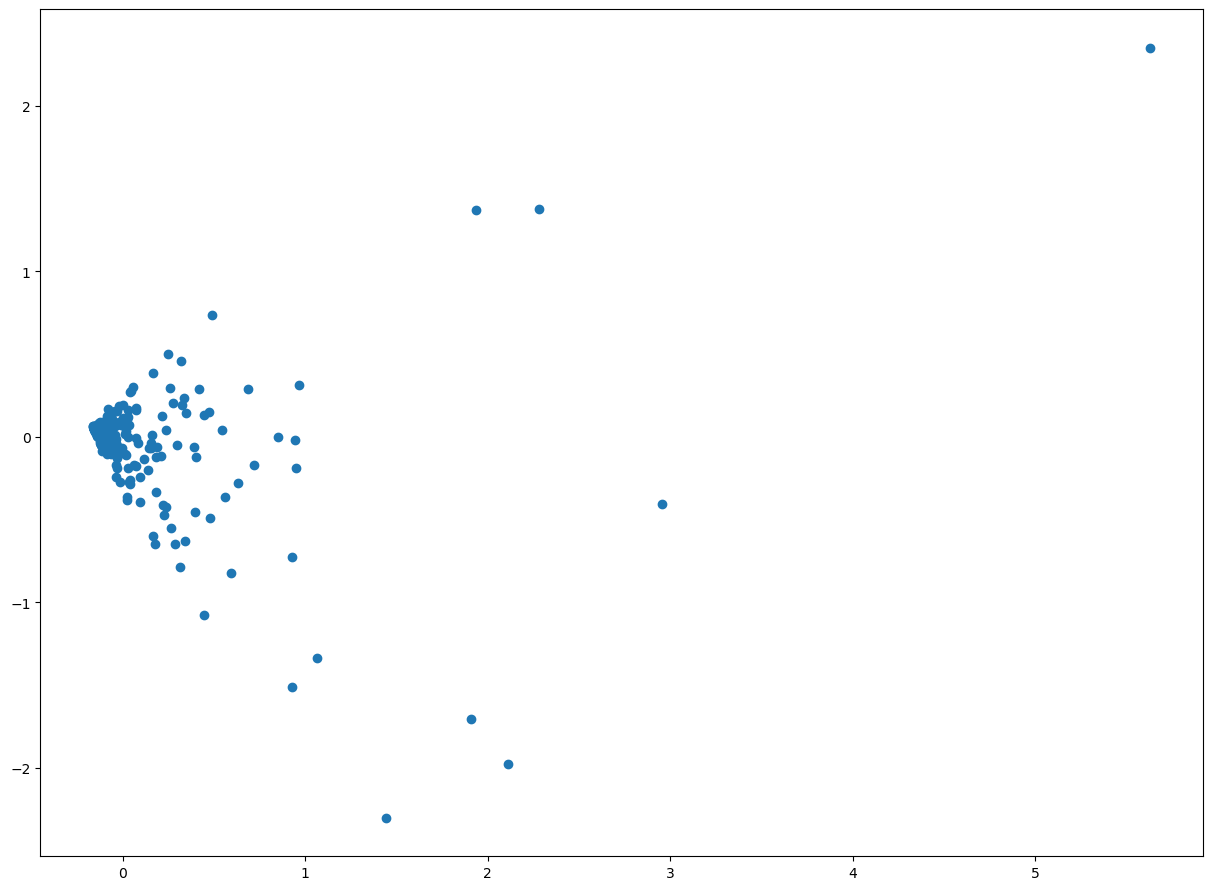

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
plt.scatter(*pca.transform(log_trans.T)[:, [0,1]].T)

kernelPCA

In [22]:
from sklearn.decomposition import KernelPCA

In [23]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(abund_hellinger.T)

In [70]:
for param in [10**(-i) for i in range(8)]:
    model = KernelPCA(kernel="rbf", gamma=param)
    model.fit(data_scaled)
    print(sum(model.eigenvalues_[:2]) / sum(model.eigenvalues_))

0.12377725108298626
0.22573719543526374
0.27402514025036967
0.24322606031297542
0.2553058618369229
0.27718918790598296
0.28024205337456287
0.2805584118551418


In [73]:
model = KernelPCA(kernel="rbf", gamma=10**(-7))
model.fit(data_scaled)

KernelPCA(gamma=1e-07, kernel='rbf')

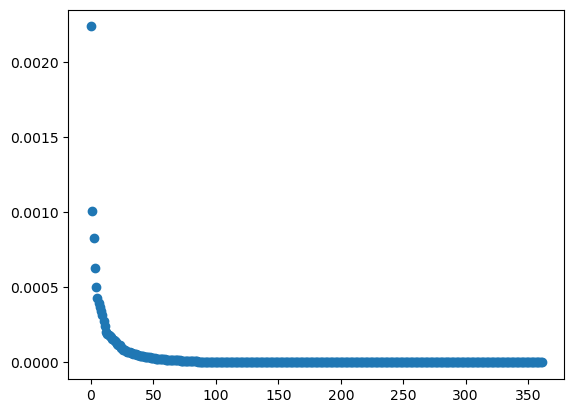

In [74]:
plt.scatter(range(len(model.eigenvalues_)), model.eigenvalues_)

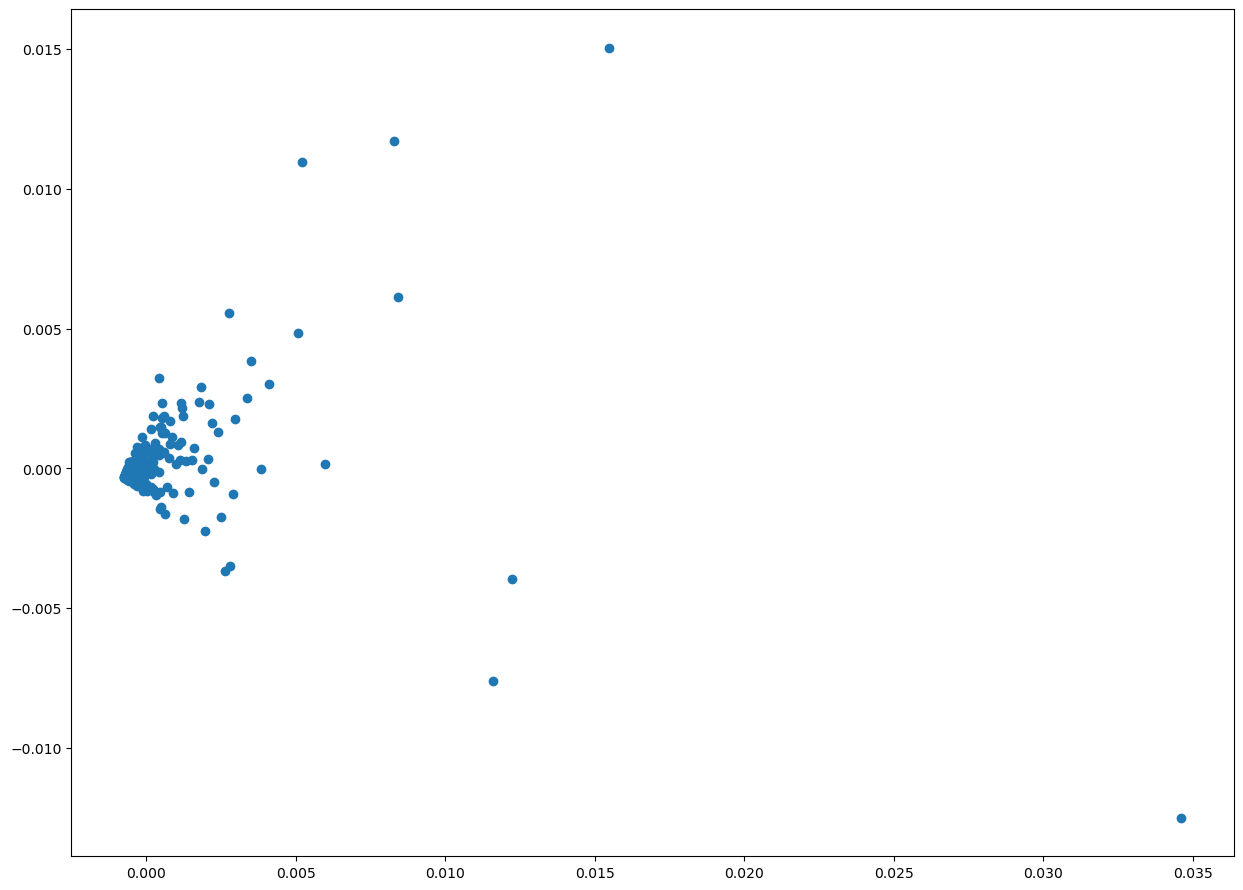

In [75]:
fig, ax = plt.subplots(1,1, figsize=(15, 11))
plt.scatter(*model.transform(data_scaled)[:, [0,1]].T)

Trying graph theory

In [6]:
import networkx as nx

In [7]:
species = abund.columns
n_species = len(species)
n_cooccur = np.zeros((n_species, n_species), dtype=int)

In [8]:
bool_species = abund.astype(bool).to_numpy()

In [9]:
for i in range(n_species): 
    for j in range(i + 1, n_species):
        n_cooccur[i,j] = np.sum(np.logical_and(bool_species[:, i], bool_species[:, j]))

In [10]:
G = nx.from_numpy_array(n_cooccur)

In [11]:
G_sub = G.subgraph(list(set(item for t in list(G.edges()) for item in t)))

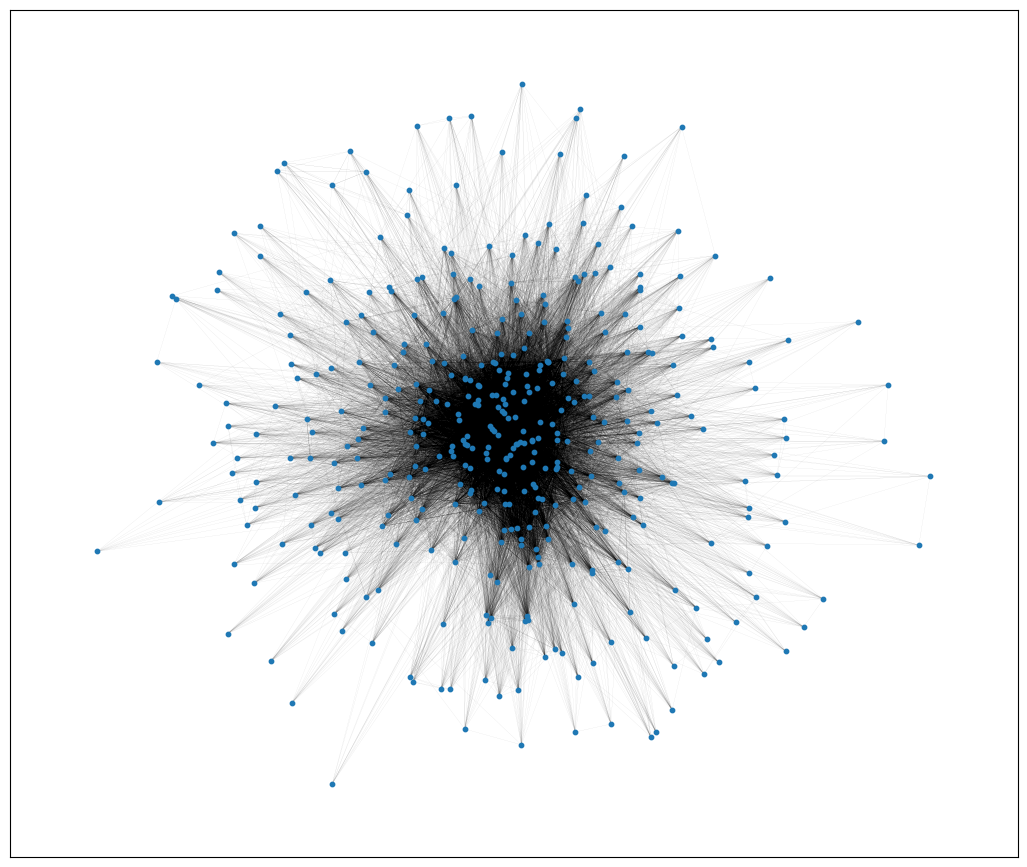

In [12]:
weight = np.array([d["weight"] for (_,_, d) in G_sub.edges(data = True)])
weight = weight / max(weight)
fig, ax = plt.subplots(1,1, figsize=(13, 11))
pos = nx.spring_layout(G_sub)
nx.draw_networkx_nodes(G_sub, ax = ax, pos = pos, node_size = 10)
nx.draw_networkx_edges(G_sub, ax = ax, pos = pos, width=weight)

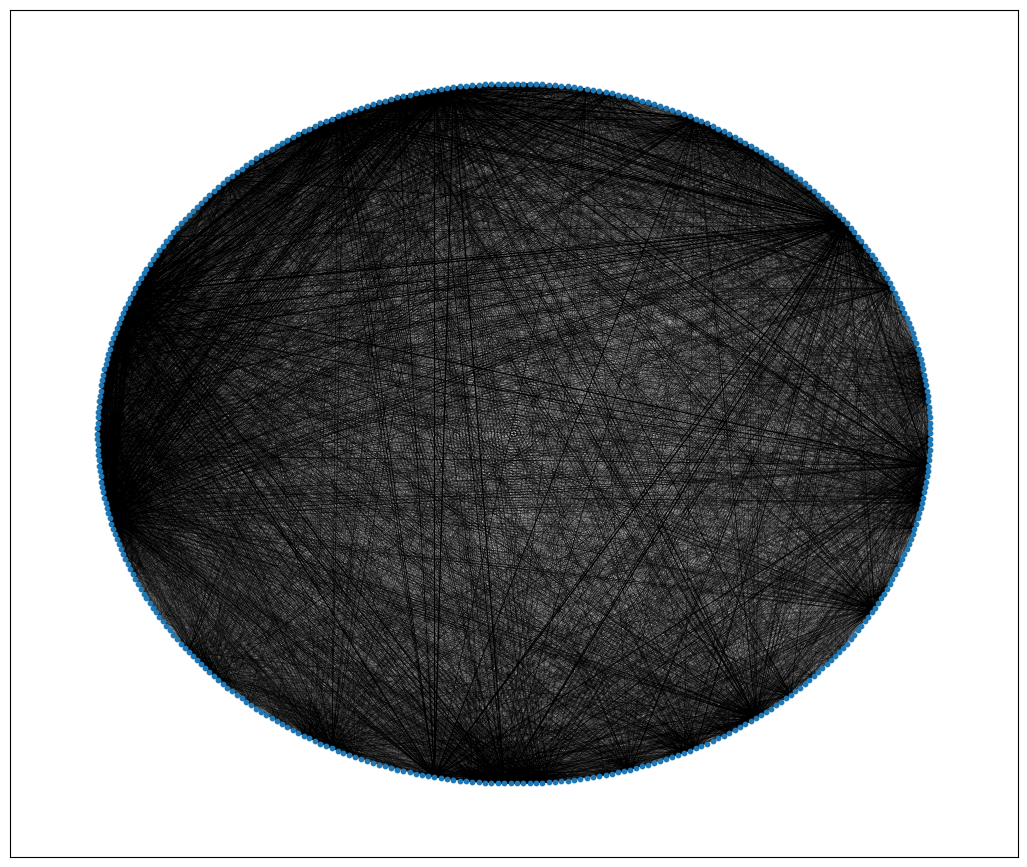

In [13]:
fig, ax = plt.subplots(1,1, figsize=(13, 11))
pos = nx.circular_layout(G_sub)
nx.draw_networkx_nodes(G_sub, ax = ax, pos = pos, node_size = 10)
nx.draw_networkx_edges(G_sub, ax = ax, pos = pos, width=weight)

## Group genera

In [157]:
col_to_group = ["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Genus"]

In [183]:
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("sp\.|cf.\s.*", "spp.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Bacillariophyceae.*", "Diatomee indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Bacillariophyta.*", "Diatomee indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chlorodendrophyceae.*", "Chlorophyta indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chlorophyceae.*", "Chlorophyta indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chroococcales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Chrysophyceae.*", "Chrysophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Coccolithophyceae.*", "Coccolithophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Dinophyceae indet. (ø inf. 20µm)", "Dinoflagellata indet. (Ø inf. 20µm)", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Dinophyceae indet. (ø sup. 20µm)", "Dinoflagellata indet. (Ø sup. 20µm)", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Noctilucea indet.", "Dinoflagellata indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Euglenophyceae.*", "Euglenophyceae indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Gymnodiniaceae.*|Gymnodiniales.*", "Gymnodiniales indet.", regex = True)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Naviculaceae indet.", "Diatomee indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Oscillatoriales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Pedinellales indet.", "Cyanophyceae indet.", regex = False)
phyto_abund_simplified.loc[:, "Taxon"] = phyto_abund_simplified.loc[:, "Taxon"].str.replace("Peridiniales.*", "Peridiniales indet.", regex = True)

In [184]:
phyto_abund_simplified = phyto_abund_simplified.groupby(col_to_group + ["Taxon"]).sum().reset_index()

In [193]:
relative_abund = None
dates = phyto_abund_simplified["Date"].between(datetime.datetime(2017,5,1), datetime.datetime(2017,5,31))
for (region_name, df_region) in phyto_abund_simplified.loc[dates, ["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby("Region"): 
    relative_abund_reg = find_most_representative_species(df_region.drop(columns="Region"), groupby_columns= ["id", "Date"], taxon_column="Taxon",  numeric_column = "Num_cell_l", threshold=1.1, relative_abundance=False)
    relative_abund_reg.reset_index(level = "Taxon", inplace=True)
    relative_abund_reg = relative_abund_reg[~relative_abund_reg["Taxon"].str.contains("Other")]
    relative_abund_reg = pd.pivot_table(relative_abund_reg, index= "id", columns = "Taxon", values="Num_cell_l").fillna(0).T
    relative_abund_reg.columns = pd.MultiIndex.from_tuples((region_name, station_id) for station_id in relative_abund_reg.columns)
    if relative_abund is None: 
        relative_abund = relative_abund_reg
    else: 
        relative_abund = pd.merge(left=relative_abund, right=relative_abund_reg, how = "outer", left_index=True, right_index=True)
relative_abund.fillna(0,inplace=True)
del relative_abund_reg

In [194]:
relative_abund

Abruzzo                       Basilicata  \
                        1_ABR_VA13 1_ABR_VA14 1_ABR_VA15 M1_SINNI_1   
Taxon                                                                 
Acanthoica quattrospina        0.0        0.0        0.0       0.00   
Achradina pulchra              0.0        0.0        0.0       0.00   
Achradina spp.                 0.0        0.0        0.0       0.00   
Akashiwo sanguinea             0.0        0.0        0.0       0.00   
Alexandrium insuetum           0.0        0.0        0.0       0.00   
...                            ...        ...        ...        ...   
Torodinium robustum            0.0        0.0        0.0    2551.25   
Torodinium spp.                0.0        0.0        0.0       0.00   
Torodinium teredo              0.0        0.0        0.0       0.00   
Trachelomonas spp.             0.0        0.0        0.0       0.00   
Vicicitus globosus             0.0        0.0        0.0       0.00   

                                                  Calabria                     \
                          M1_SINNI_2   M1_SINNI_3    M1T1A  M1T1B M1T1C M1T3A   
Taxon                                                                           
Acanthoica quattrospina     0.000000     0.000000      0.0    0.0   0.0   0.0   
Achradina pulchra           0.000000     0.000000      0.0    0.0   0.0   0.0   
Achradina spp.              0.000000     0.000000      0.0    0.0   0.0   0.0   
Akashiwo sanguinea          0.000000     0.000000      0.0    0.0   0.0   0.0   
Alexandrium insuetum        0.000000     0.000000      0.0    0.0   0.0   0.0   
...                              ...          ...      ...    ...   ...   ...   
Torodinium robustum      3280.178571  4009.107143      0.0  120.0  60.0   0.0   
Torodinium spp.             0.000000     0.000000      0.0    0.0   0.0   0.0   
Torodinium teredo           0.000000     0.000000      0.0    0.0   0.0   0.0   
Trachelomonas spp.          0.000000     0.000000      0.0    0.0   0.0   0.0   
Vicicitus globosus          0.000000     0.000000      0.0    0.0   0.0   0.0   

                         ...     Toscana                                      \
                         ... SMR_CCE_WA5 SMR_CPI_WA1 SMR_CPI_WA3 SMR_CPI_WA5   
Taxon                    ...                                                   
Acanthoica quattrospina  ...        83.0        38.0         0.0         0.0   
Achradina pulchra        ...         0.0         0.0         0.0         0.0   
Achradina spp.           ...         0.0         0.0         0.0         0.0   
Akashiwo sanguinea       ...         0.0         0.0         0.0         0.0   
Alexandrium insuetum     ...         0.0         0.0         0.0         0.0   
...                      ...         ...         ...         ...         ...   
Torodinium robustum      ...       104.0       345.0       103.0         0.0   
Torodinium spp.          ...         0.0         0.0         0.0         0.0   
Torodinium teredo        ...         0.0         0.0         0.0         0.0   
Trachelomonas spp.       ...         0.0         0.0         0.0         0.0   
Vicicitus globosus       ...         0.0         0.0         0.0         0.0   

                         Veneto                                
                          50530 50720 60530 60720 70530 70720  
Taxon                                                          
Acanthoica quattrospina     0.0   0.0   0.0   0.0   0.0   0.0  
Achradina pulchra           0.0   0.0   0.0   0.0   0.0   0.0  
Achradina spp.              0.0   0.0   0.0   0.0   0.0   0.0  
Akashiwo sanguinea          0.0   0.0   0.0   0.0   0.0   0.0  
Alexandrium insuetum        0.0   0.0   0.0   0.0   0.0   0.0  
...                         ...   ...   ...   ...   ...   ...  
Torodinium robustum      2268.0   0.0   0.0   0.0   0.0   0.0  
Torodinium spp.             0.0   0.0   0.0   0.0   0.0   0.0  
Torodinium teredo           0.0   0.0   0.0   0.0   0.0   0.0  
Trachelo

In [202]:
frequencies = phyto_abund_simplified.loc[:, ["Taxon", "Num_cell_l"]].groupby("Taxon").count().rename(columns={"Num_cell_l": "Freq"}).reset_index().sort_values(by = "Freq", ascending=False)

<Axes: xlabel='Freq', ylabel='Probability'>

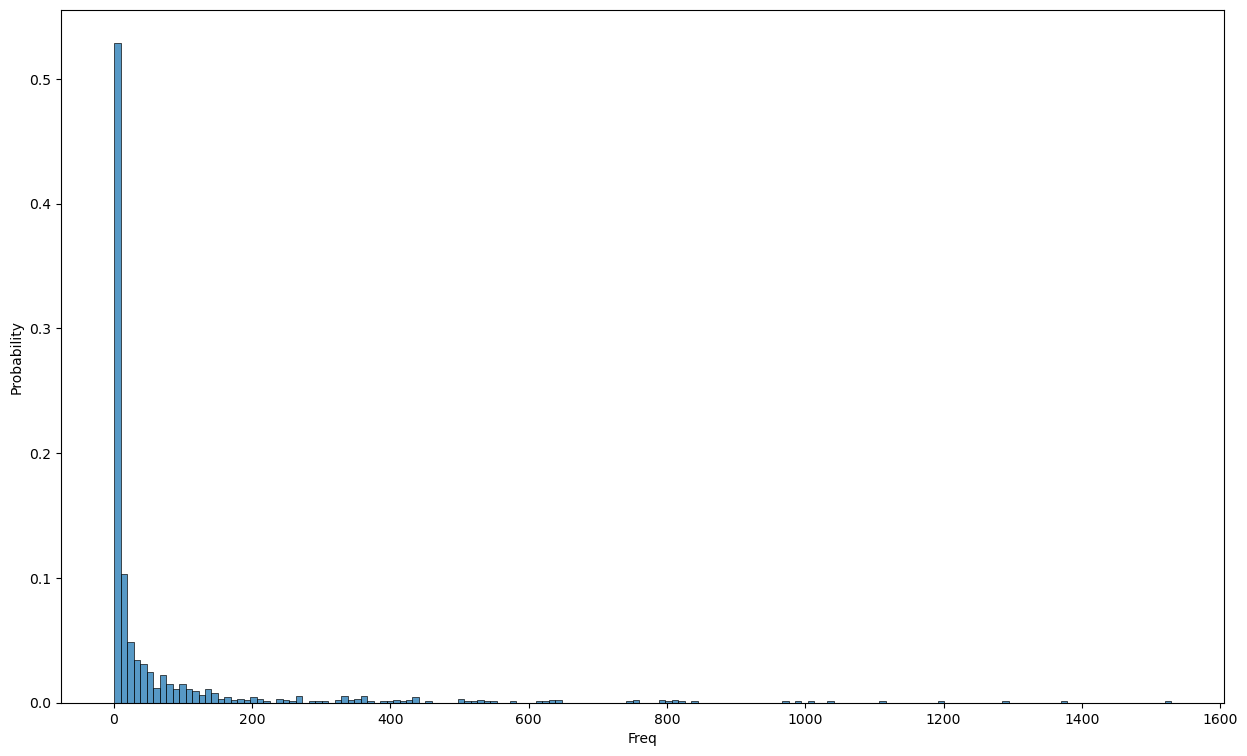

In [207]:
fig, ax = plt.subplots(1,1, figsize = (15,9))
sns.histplot(frequencies, x = "Freq", ax = ax, stat="probability")